#  Breast Cancer Diagnosis via Logistic Regression

In this demo, we will see how to visualize training data for classification, plot the logistic function and perform logistic regression.  As an example, we will use the widely-used breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.  In going through this demo, you will learn to:

* Use a colored scatter plot to visualize data to be classified
* Mathematically describe logistic classification rules
* Fit logistic classifiers using `sklearn`
* Measure the accuracy of the classifers
* Visualize the output probabilities
* Measure TPR, FPR and plot a ROC curve

## Loading and Visualizing the Data

We first load the packages as usual.

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing

Next, we load the data from the UCI site.  It is important to remove the missing values.

In [4]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head(6)

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


After loading the data, we can create a scatter plot of the data labeling the class values with different colors.  We will pick two of the features.  

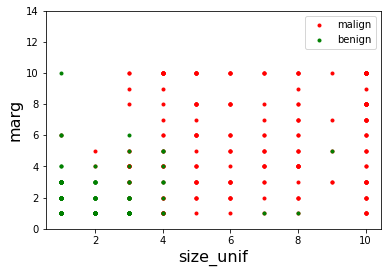

In [5]:
# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0)
Imal = (y==1)

# Get two predictors
xnames =['size_unif','marg'] 
X = np.array(df[xnames])

# Create the scatter plot
plt.plot(X[Imal,0],X[Imal,1],'r.')
plt.plot(X[Iben,0],X[Iben,1],'g.')
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

One way to improve the plot is to draw circles on each point whose size is proportional to the count of samples at that point.  We will re-use this code, so we define a function. 

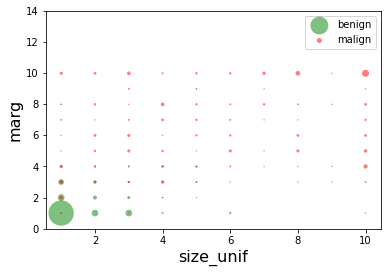

In [6]:
def plot_cnt(X,y,legend=True):
    
    # Compute the bin edges for the 2d histogram
    x0val = np.array(list(set(X[:,0]))).astype(float)
    x1val = np.array(list(set(X[:,1]))).astype(float)
    x0, x1 = np.meshgrid(x0val,x1val)
    x0e= np.hstack((x0val,np.max(x0val)+1))
    x1e= np.hstack((x1val,np.max(x1val)+1))

    # Make a plot for each class
    yval = list(set(y))
    color = ['g','r']
    for i in range(len(yval)):
        I = np.where(y==yval[i])[0]
        cnt, x0e, x1e = np.histogram2d(X[I,0],X[I,1],[x0e,x1e])
        x0, x1 = np.meshgrid(x0val,x1val)
        plt.scatter(x0.ravel(), x1.ravel(), s=2*cnt.ravel(),alpha=0.5,
                    c=color[i],edgecolors='none')
    if legend:
        plt.ylim([0,14])
        plt.legend(['benign','malign'], loc='upper right')
        plt.xlabel(xnames[0], fontsize=16)
        plt.ylabel(xnames[1], fontsize=16)   
        
plot_cnt(X,y)

## In-Class Exercise

Based on the above plot, what would be a good "classifer" using the two features.  That is, write a function that makes a prediction `yhat` of the class label `y`.  Code up your classifier function.  Measure the accuracy of the classifier on the data.  What percentage error does your classifier get?

In [7]:
# TODO

# Linear classfier: If size_unf+marg<=4.5, benign.
def simple_classifier(features):
    return (features[:,0]+features[:,1])>4.5
    #return (2*features[:,0]+3*features[:,1])>17


yhat=simple_classifier(X)
accuracy=np.mean(yhat==y)
print (accuracy)

0.9282576866764275


## Some Simple Classification Ideas

Here are some ideas for classification that you may have already thought of.  We can see that the benign samples are located in the lower left.  So, one simple classification rule is to define the region with a line.  We plot the region for one possible line with the following code.

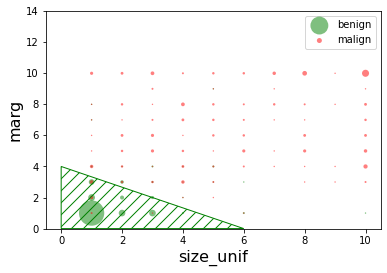

In [8]:
from matplotlib import patches
plot_cnt(X,y)

ax = plt.gca() 
ax.add_patch(
    patches.Polygon([[0,0],[0,4],[6,0]],
        color='green',
        fill=False, hatch = '//'
    )
)

Here is an alternate classification rule based on two linear constraints.

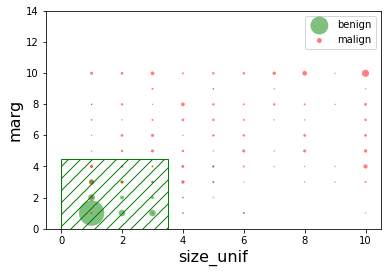

In [9]:
plot_cnt(X,y)
ax = plt.gca()
ax.add_patch(
    patches.Rectangle(
        (0, 0),   # (x,y)
        width=3.5, height=4.5,  color='green',
        fill=False, hatch = '//'
    )
)

## Logistic Functions


Both the above two classification rules will work well.  But, in general, manually selecting rules from visual inspection is hard.  This demo we will show to fit a type of classifier called *logistic regression*.  In logistic regression, we do not just output an estimate of the class label, `yhat`.  Instead, we ouput a *probability*, an estimate of how likely the sample is one class or the other.  That is our output is a number from 0 to 1 representing the likelihood:
$$
    P(y = 1|x)
$$
which is our estimate of the probability that the sample is one class (in this case, a malignant sample) based on the features `x`.  This is sometimes called a *soft classifier*.  

In logistic regression, we assume that likelihood is of the form
$$
    P(y=1|x) = f(z),  \quad z = w_0 + w_1x_1 + \cdots + w_kx_k,  
$$
where $w_0,\ldots,w_k$ are the classifier weights and $f(z)$ is the so-called *logistic* function:
$$
    f(z) = \frac{1}{1+e^{-z}}.
$$

To understand the logistic function, suppose $x$ is a scalar and samples $y$ are drawn with $P(y=1|x) = f(w_1x)$ for some scaling constant $w_1$.  We plot these samples for different $w_1$.

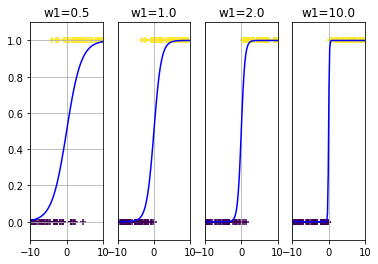

In [10]:
nx = 100
xm = 10
w1s = np.array([0.5,1,2,10])
nplot = w1s.size
iplot = 0
for w1 in w1s:
    iplot += 1
    x  = np.random.uniform(-xm,xm,nx)
    plt.subplot(1,nplot,iplot)
    py = 1/(1+np.exp(-w1*x))
    yp = np.array(np.random.rand(nx) < py)
    xp = np.linspace(-xm,xm,100)
    pyp = 1/(1+np.exp(-w1*xp))

    plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')
    plt.plot(xp,pyp,'b-')
    plt.axis([-xm,xm,-0.1,1.1])
    plt.grid()
    if (iplot > 1):
        plt.yticks([])
    plt.xticks([-10,0,10])
    plt.title('w1={0:.1f}'.format(w1))


We see that $f(w_1x)$ represents the probability that $y=1$.  The function $f(w_1x) > 0.5$ for $x>0$ meaning the samples are more likely to be $y=1$.  Similarly, for $x<0$, the samples are more likely to $y=0$.  The scaling $w_1$ determines how fast that transition is.

## Fitting the Logistic Model on Two  Variables

In a logistic model, we must fit the weights `w_0,w_1,...,w_k`  in the model 

    P(y=1|x) = f(z)=1/(1+exp(-z)),  z = w_0 + w_1x_1 + ... + w_kx_k.
    
For the purpose of visualization, we will first fit the model on the two variables `size_unif` and `marg` that we were looking at earlier.

In [11]:
xnames =['size_unif','marg'] 
X = np.array(df[xnames])
print(X.shape)

(683, 2)


Next we split the data into training and test

In [12]:
# Split into training and test
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.30)

Similar to the linear regression, we generally scale the variables before fitting.

In [13]:
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
Xtr1 = scal.fit_transform(Xtr)
Xts1 = scal.transform(Xts)

The actually fitting is now easy with the `sklearn` package.  The parameter `C` states the level of regularization with higher values meaning less regularization.  Right now, we will select a high value to minimally regularize the estimate.

In [14]:
reg = linear_model.LogisticRegression(C=1e5)
reg.fit(Xtr1, ytr)

LogisticRegression(C=100000.0)

Finally, we can measure the accuracy on the test data.  You should get an accuracy around 93%.  This may be similar to what you designed by hand.

In [15]:
yhat = reg.predict(Xts1)
acc = np.mean(yhat == yts)
print("Accuracy on test data = %f" % acc)

Accuracy on test data = 0.946341


It is useful to plot the probabilities as a function of the two variables.  The plot below plots the data points along with a blue color that indicates the probability that the logistic model assigns to each point that the point is malignant.  We see points in the lower left are assigned low probabilities while the upper right are assigned high probabilities.

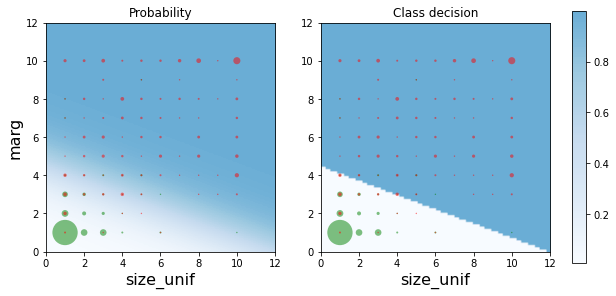

In [16]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

blue_map = cm.get_cmap('Blues')
light_map = ListedColormap(blue_map(np.linspace(0,0.5,100)))

# Create grid of points to plot the data
xmin = np.array([0,0])
xmax = np.array([12,12])
nplot = 100
xp0 = np.linspace(xmin[0], xmax[0], nplot)
xp1 = np.linspace(xmin[1], xmax[1], nplot)
Xp0, Xp1 = np.meshgrid(xp0,xp1)
Xplot = np.column_stack((Xp0.ravel(), Xp1.ravel()))
Zplot = scal.transform(Xplot)


prob = reg.predict_proba(Zplot)[:,1]
prob_mat = np.fliplr(prob.reshape((nplot, nplot))).T

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
im = plt.imshow(prob_mat, extent=[xmin[0],xmax[0],xmin[1],xmax[1]], cmap=light_map)
plot_cnt(X,y, legend=False)
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.title('Probability')

plt.subplot(1,2,2)
yhat = (prob_mat > 0.5).astype(float)
plt.imshow(yhat, extent=[xmin[0],xmax[0],xmin[1],xmax[1]], cmap=light_map)
plot_cnt(X,y, legend=False)
plt.xlabel(xnames[0], fontsize=16)
plt.title('Class decision')


plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8) 
cb_ax = plt.gcf().add_axes([0.83, 0.15, 0.02, 0.7])
plt.colorbar(im, cax=cb_ax)

## Fitting the Model on all the Variables

We can now easily fit the model on all 9 variables.  First, we get the variables removing the first column (for the index) and the last column (for the target). Then, we split into train and test.

In [17]:
# Get array of all the features, except the ID (in the first column)
# and target variable (in the last column)
xnames = names[1:-1]
X = np.array(df[xnames])
print(X.shape)

# Split into training and test
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.30)

(683, 9)


Now we repeat the above procedure used for the two variable case:  We scale the training and test, fit the model on the training data and score on the test data.  We see we get a little better accuracy.  The result will be around 97% accuracy depending on the train-test split.

In [18]:
# Scale the data
scal = StandardScaler()
Xtr1 = scal.fit_transform(Xtr)
Xts1 = scal.transform(Xts)

# Fit on the scaled trained data
reg = linear_model.LogisticRegression(C=1e5)
reg.fit(Xtr1, ytr)

# Measure accuracy
yhat = reg.predict(Xts1)
acc = np.mean(yhat == yts)
print("Accuracy on test data = %f" % acc)

Accuracy on test data = 0.975610


It is also useful to print the weights for each feature.  We can use the `pandas` package to make a table. 

In [19]:
W=reg.coef_
data = {'feature': xnames, 'slope': np.squeeze(W)}
dfslope = pd.DataFrame(data=data)
dfslope

,feature,slope
0,thick,1.456914
1,size_unif,-0.354445
2,shape_unif,0.901434
3,marg,1.191876
4,cell_size,0.317604
5,bare,1.523286
6,chrom,1.066310
7,normal,0.655382
8,mit,1.164882


## Cross-Validation

The above code measured the one train-test split.  Since there is some variation across splits, we can use K-fold validation.  We perform 10-fold cross-validation and print average precision, recall, f1-score and accuracy.


In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold)
acc = np.zeros(nfold)
prec = np.zeros(nfold)
rec = np.zeros(nfold)
f1 = np.zeros(nfold)

for i, I in enumerate(kf.split(X)):
    
    # Get training and test data
    train, test = I
    Xtr = X[train,:]
    ytr = y[train]
    Xts = X[test,:]
    yts = y[test]
    
    # Scale the data
    scal = StandardScaler()
    Xtr1 = scal.fit_transform(Xtr)
    Xts1 = scal.transform(Xts)    
    
    # Fit a model    
    reg.fit(Xtr1, ytr)
    
    # Predict on test samples and measure accuracy
    yhat = reg.predict(Xts1)
    acc[i] = np.mean(yhat == yts)
    
    # Measure other performance metrics
    prec[i],rec[i],f1[i],_  = precision_recall_fscore_support(yts,yhat,average='binary') 
    

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Precision = 0.9610, SE=0.0118
Recall =    0.9615, SE=0.0144
f1 =        0.9608, SE=0.0112
Accuracy =  0.9679, SE=0.0110


## ROC curve

As discussed above, the logistic classifier outputs a *soft* classification $P(y=1|x)$.  One simple idea is to select the class label $\hat{y}=1$ whenever $P(y=1|x) > 0.5$.  However, one can also set $\hat{y}=1$ whenever $P(y=1|x) > t$ for some threshold $t$.  Using higher thresholds values selects $\hat{y}=0$ more often which results in fewer *false alarms*, but also many *missed detections* (reduces sensitivity).  Similarly, lower thresholds values selects $\hat{y}=1$ more often which results in fewer *missed detections* (increases *sensitivity*) but also more *false alarms*.  The ROC curve displays this  tradeoff by graphing the *true positive rate* vs. *false positive rate* obtained with different $t$.  

The ROC curve can be plotted in the `sklearn` package with the following code.

(0.0, 0.1)

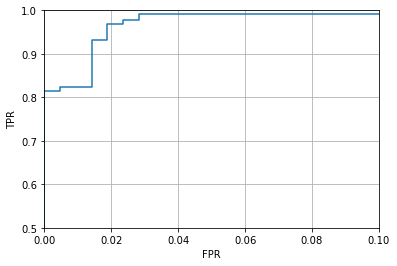

In [19]:
# Split into training and test
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.50)


# Scale the data
scal = StandardScaler()
Xtr1 = scal.fit_transform(Xtr)
Xts1 = scal.transform(Xts)

# Fit on the scaled trained data
reg = linear_model.LogisticRegression(C=1e5)
reg.fit(Xtr1, ytr)

# Predict probability on the test data
yprob = reg.predict_proba(Xts1)

# Compute FPR and TPR
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yts,yprob[:,1])

plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.5,1])
plt.xlim([0,0.1])

Now let us see what are the relation between the threshold and the TPR and FPR.

(0.0, 1.0)

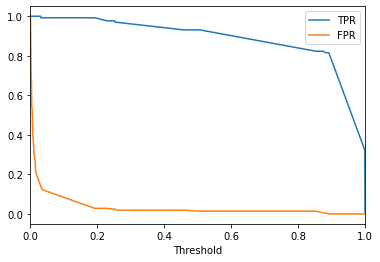

In [20]:
plt.plot(thresholds,tpr, thresholds,fpr)
plt.legend(['TPR','FPR'])
plt.xlabel('Threshold')
plt.xlim([0,1])

The goodness of a classification method is often measured by the area under the curve (AUC), which is independent of the threshold. A method with a higher AUC means that under the same FPR, it has higher PPR. Note that in practice, you should evalute UAC in different cross validation folds and then evaluate the mean AUC.

In [21]:
auc=metrics.roc_auc_score(yts,yprob[:,1])
print("AUC=%f" % auc)

AUC=0.996009
